In [2]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('..')

In [7]:
% cd '/content/drive/MyDrive/NYU/Project/GCN/Starting/Notebooks'


/content/drive/MyDrive/NYU/Project/GCN/Starting/Notebooks


* Install the GCN libraries by Defferard.
* These were used by Jia et al. as a template to write their code.


In [8]:
from Lib import GCN_Model, graph, coarsening

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import sparse
device = 'cuda:0'
%matplotlib inline

In [10]:
# Clear all the stack and use GPU resources as much as possible
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [11]:
train_data = pd.read_csv ('/content/drive/MyDrive/NYU/Project/GCN/Starting/Imaginary Data/CSV Files/All Electrodes/training_set.csv', header=None)
train_labels = pd.read_csv ('/content/drive/MyDrive/NYU/Project/GCN/Starting/Imaginary Data/CSV Files/All Electrodes/training_label.csv', header=None)
val_data = pd.read_csv ('/content/drive/MyDrive/NYU/Project/GCN/Starting/Imaginary Data/CSV Files/All Electrodes/val_set.csv', header=None)
val_labels = pd.read_csv ('/content/drive/MyDrive/NYU/Project/GCN/Starting/Imaginary Data/CSV Files/All Electrodes/val_label.csv', header=None)
test_data = pd.read_csv ('/content/drive/MyDrive/NYU/Project/GCN/Starting/Imaginary Data/CSV Files/All Electrodes/test_set.csv', header=None)
test_labels = pd.read_csv ('/content/drive/MyDrive/NYU/Project/GCN/Starting/Imaginary Data/CSV Files/All Electrodes/test_label.csv', header=None)

In [ ]:
train_data = train_data.to_numpy()
train_data = train_data.astype('float32')
train_labels = train_labels.to_numpy()
train_labels = train_labels.astype('int32')
val_data = val_data.to_numpy()
val_data = val_data.astype('float32')
val_labels = val_labels.to_numpy()
val_labels = val_labels.astype('int32')
test_data = test_data.to_numpy()
test_data = test_data.astype('float32')
test_labels = test_labels.to_numpy()
test_labels = test_labels.astype('int32')
train_labels=train_labels.reshape(430080,)
val_labels= val_labels.reshape(53760,)
test_labels= test_labels.reshape(53760,)


In [16]:
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)

(430080, 64)
(430080,)
(53760, 64)
(53760,)


In [17]:
type(train_data)

numpy.ndarray

In [18]:
Adjacency_Matrix = pd.read_csv ('/content/drive/MyDrive/NYU/Project/GCN/Starting/Imaginary Data/CSV Files/All Electrodes/Adjacency_Matrix.csv', header=None,float_precision=32)
Adjacency_Matrix = Adjacency_Matrix.to_numpy()
Adjacency_Matrix = Adjacency_Matrix.astype('float32')
Adjacency_Matrix = sparse.csr_matrix(Adjacency_Matrix)

print('==============> Adjancy matrix read!')
print(Adjacency_Matrix.shape)

==============> Adjancy matrix read!
(64, 64)


In [19]:
graphs, perm = coarsening.coarsen(Adjacency_Matrix, levels=5, self_connections=False)


Layer 0: M_0 = |V| = 64 nodes (0 added),|E| = 2016 edges
Layer 1: M_1 = |V| = 32 nodes (0 added),|E| = 496 edges
Layer 2: M_2 = |V| = 16 nodes (0 added),|E| = 120 edges
Layer 3: M_3 = |V| = 8 nodes (0 added),|E| = 28 edges
Layer 4: M_4 = |V| = 4 nodes (0 added),|E| = 6 edges
Layer 5: M_5 = |V| = 2 nodes (0 added),|E| = 1 edges


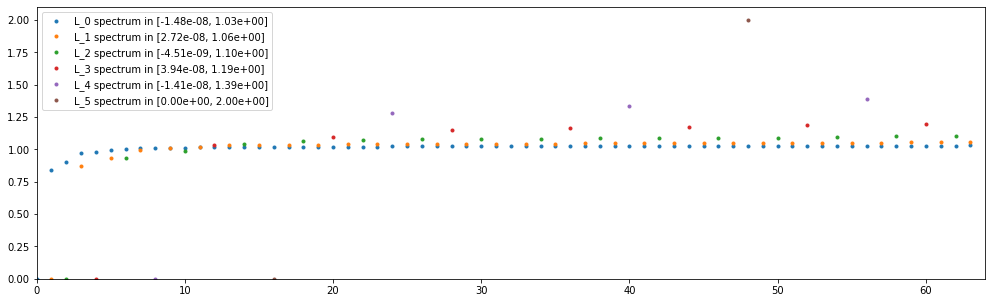

In [20]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)

In [21]:
X_train = coarsening.perm_data(train_data, perm)
X_val  = coarsening.perm_data(val_data,  perm)
X_test =  coarsening.perm_data(test_data,  perm)
print('==============>coarsening done!')

==============>coarsening done!


In [22]:
print(train_labels[1:20])

[2 0 1 1 0 2 0 0 0 0 1 0 0 0 2 1 1 3 2]


In [23]:

params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 50
params['batch_size']     = 1024
params['eval_frequency'] = 100

# Building blocks.
params['filter'] = 'chebyshev5'
params['brelu']  = 'b2relu'
params['pool']   = 'mpool1'

# Architecture.
params['F']              = [16,32,64,128,256,512]  # Number of graph convolutional filters.
params['K']              = [2,2,2,2,2,2]  # Polynomial orders.
params['p']              = [2,2,2,2,2,2]    # Pooling sizes.
params['M']              = [4]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 0.001     # L2 regularization
params['dropout']        = 0.50      # Dropout rate
params['learning_rate']  = 0.0001  # Learning rate
params['decay_rate']     = 1         # Learning rate Decay == 1 means no Decay
params['momentum']       = 0         # momentum == 0 means Use Adam Optimizer
n_train = np.shape(train_data)[0]
params['decay_steps']    = n_train/ params['batch_size']

In [24]:
!pwd

/content/drive/My Drive/NYU/Project/GCN/Starting/Notebooks


In [25]:
model = GCN_Model.cgcnn(L, **params)


NN architecture
input: M_0 = 64
layer 1: cgconv1
representation: M_0 * F_1 / p_1 = 64 * 16 / 2 = 512
weights: F_0 * F_1 * K_1 = 1 * 16 * 2 = 32
biases: M_1 * F_1 = 64 * 16 = 1024
layer 2: cgconv2
representation: M_1 * F_2 / p_2 = 32 * 32 / 2 = 512
weights: F_1 * F_2 * K_2 = 16 * 32 * 2 = 1024
biases: M_2 * F_2 = 32 * 32 = 1024
layer 3: cgconv3
representation: M_2 * F_3 / p_3 = 16 * 64 / 2 = 512
weights: F_2 * F_3 * K_3 = 32 * 64 * 2 = 4096
biases: M_3 * F_3 = 16 * 64 = 1024
layer 4: cgconv4
representation: M_3 * F_4 / p_4 = 8 * 128 / 2 = 512
weights: F_3 * F_4 * K_4 = 64 * 128 * 2 = 16384
biases: M_4 * F_4 = 8 * 128 = 1024
layer 5: cgconv5
representation: M_4 * F_5 / p_5 = 4 * 256 / 2 = 512
weights: F_4 * F_5 * K_5 = 128 * 256 * 2 = 65536
biases: M_5 * F_5 = 4 * 256 = 1024
layer 6: cgconv6
representation: M_5 * F_6 / p_6 = 2 * 512 / 2 = 512
weights: F_5 * F_6 * K_6 = 256 * 512 * 2 = 262144
biases: M_6 * F_6 = 2 * 512 = 1024
layer 7: logits (softmax)
representation: M_7 = 4
weights: M_6

In [ ]:
accuracy, loss, t_step = model.fit(X_train, train_labels, X_val, val_labels)

In [27]:
results = model.evaluate(X_test, test_labels)


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/NYU/Project/GCN/Starting/Notebooks/Lib/../checkpoints/demo/model-500


In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(accuracy, 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax1.set_ylim([0,100])
ax2 = ax1.twinx()
ax2.plot(loss, 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()


In [ ]:
import pandas
df = pandas.DataFrame(data={"Loss": loss, "Accuracy": accuracy})
df.to_csv("./LA_Imag_NoFilter.csv", sep=',',index=False)
=df = pandas.DataFrame(data={"Results": results})
df.to_csv("./Results_Imag_NoFilter.csv", sep=',',index=False)